In [1]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [2]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

RESULTS_PATH_SITE = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_site.csv'

RESULTS_PATH_PATHO = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_patho.csv'

METHODS = ['raw', 'sitewise', 'combat']

PCA_VARIANTS = [1.0, 0.99, 0.95, 0.90, 0.80]

In [11]:
results_df = pd.read_csv(RESULTS_PATH_PATHO)

In [12]:
results_df = results_df[results_df['method'] != 'neurocombat']

results_df['pca_var'] = results_df['pca_var'].fillna(1.0)

all_methods = sorted(results_df['method'].unique())
all_pca = sorted(results_df['pca_var'].unique())
all_hospitals = sorted(results_df['hospital'].unique())

metrics_to_plot = ["auc", "mcc"]

color_grid = [
    'black', 'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]


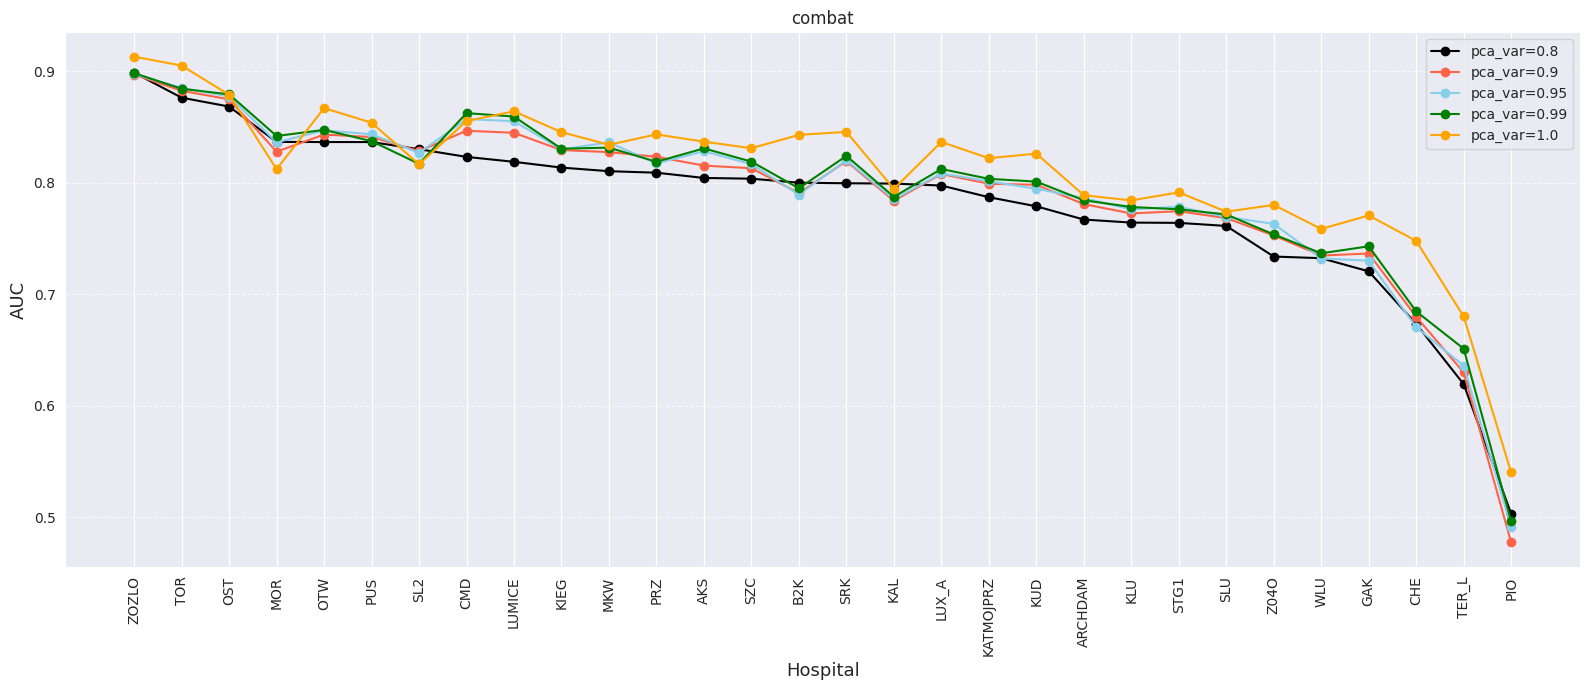

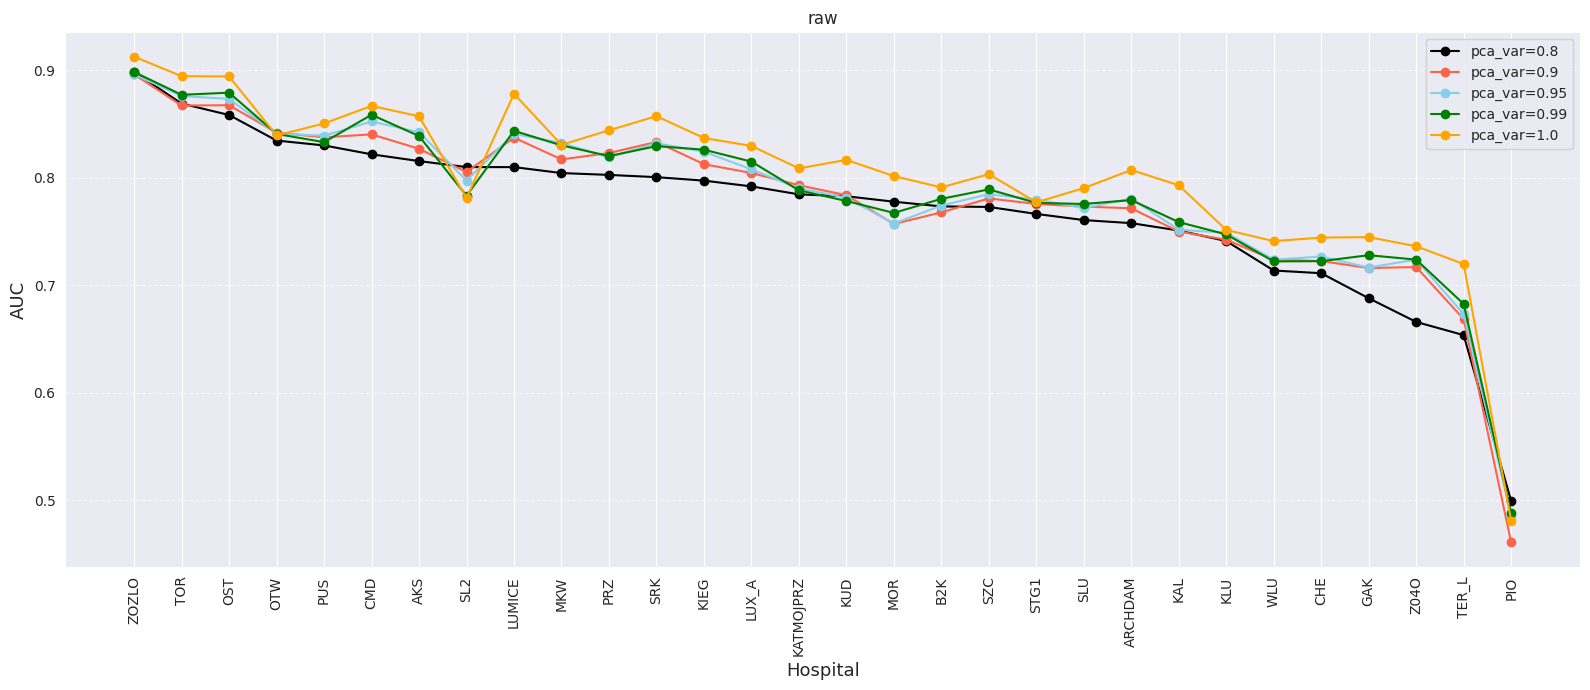

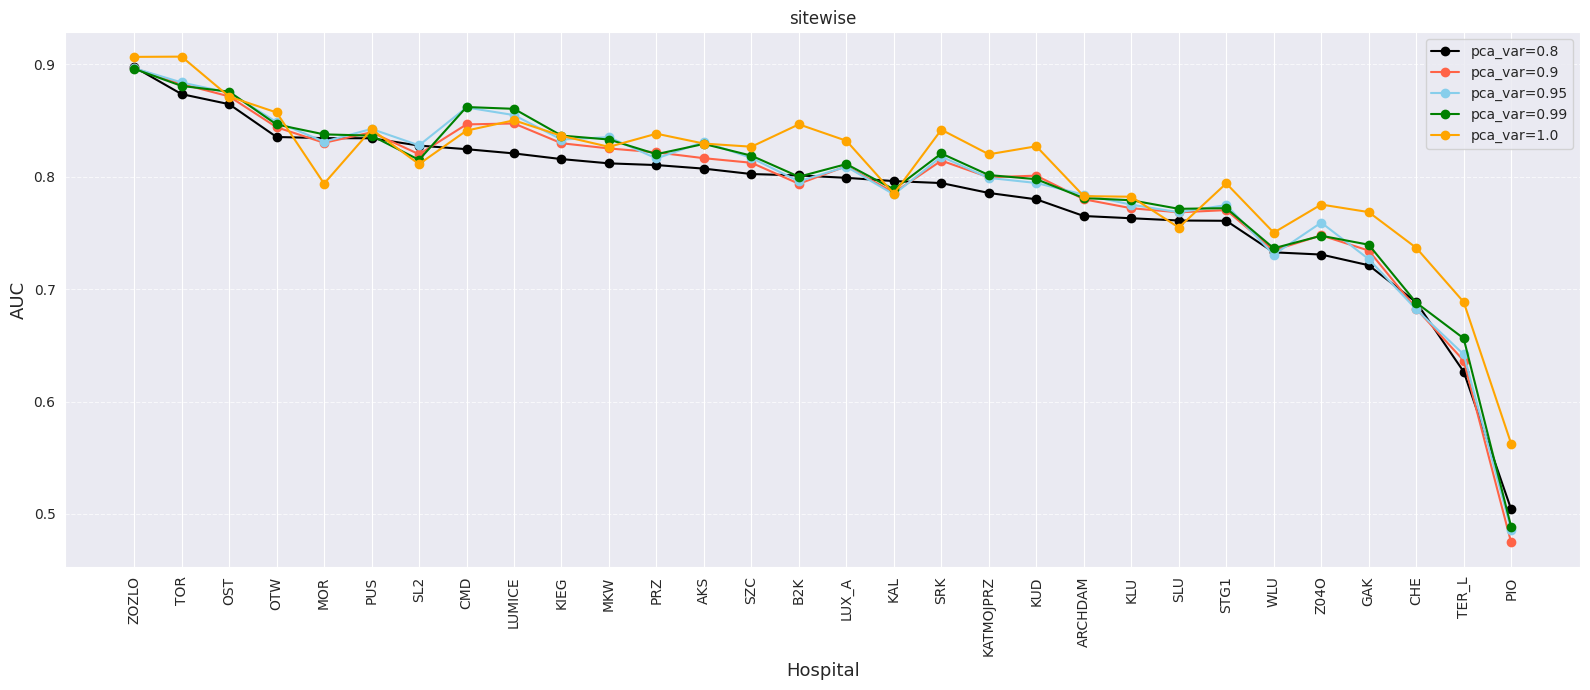

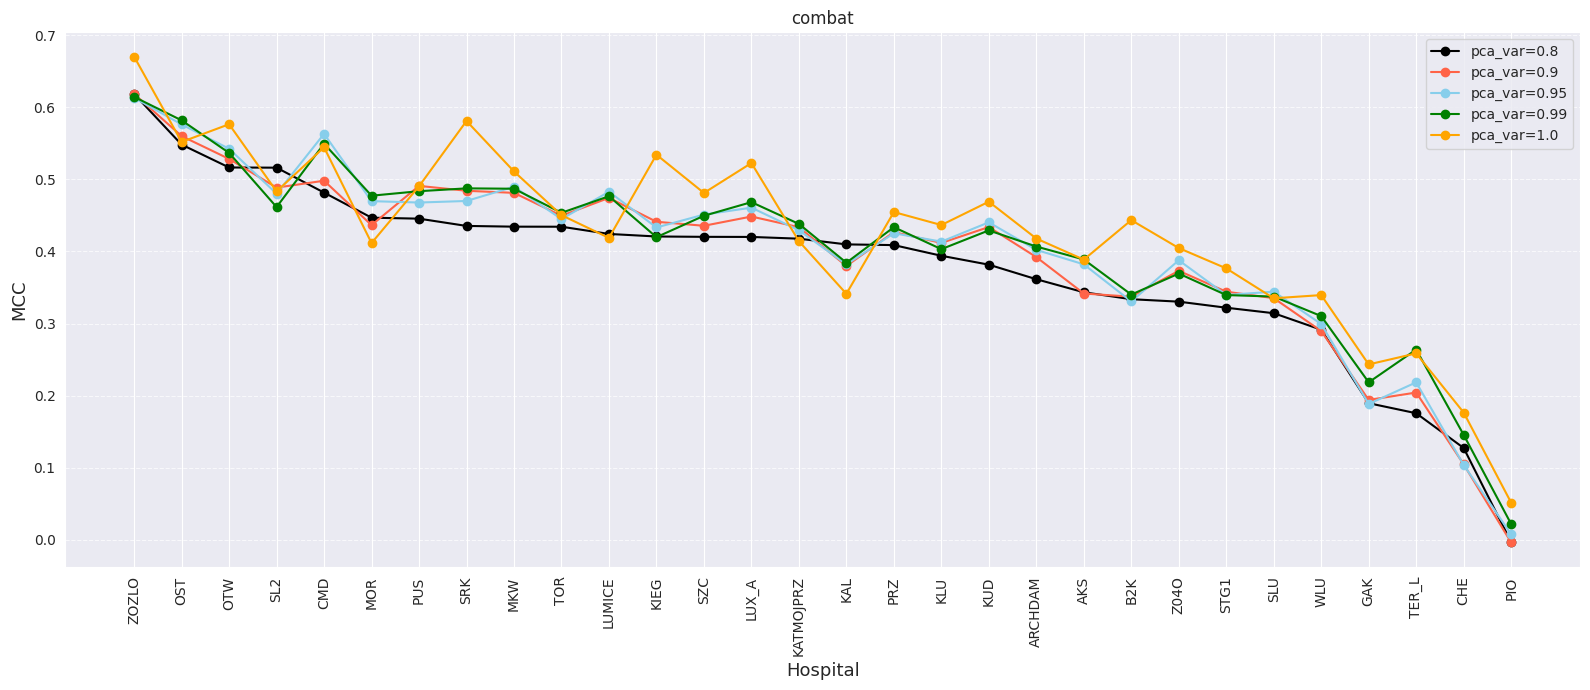

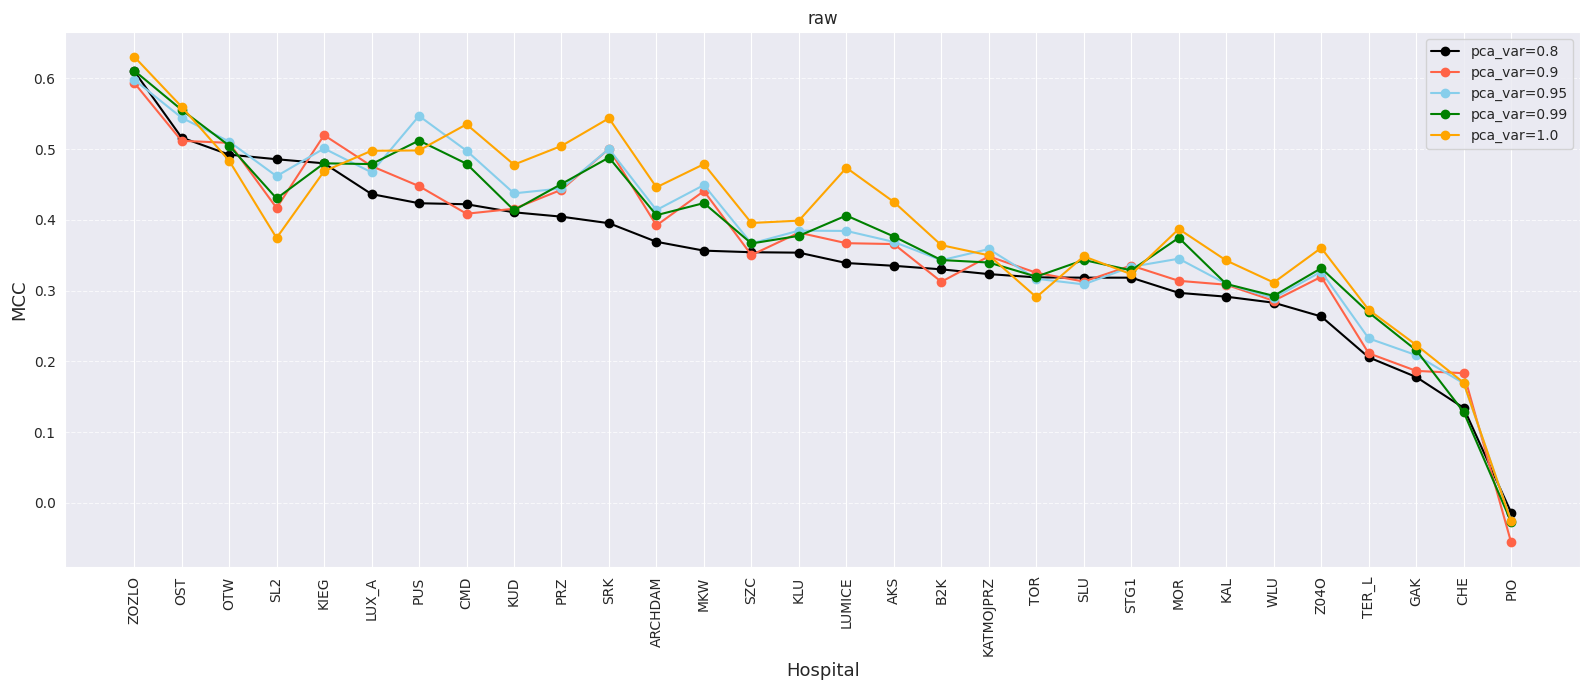

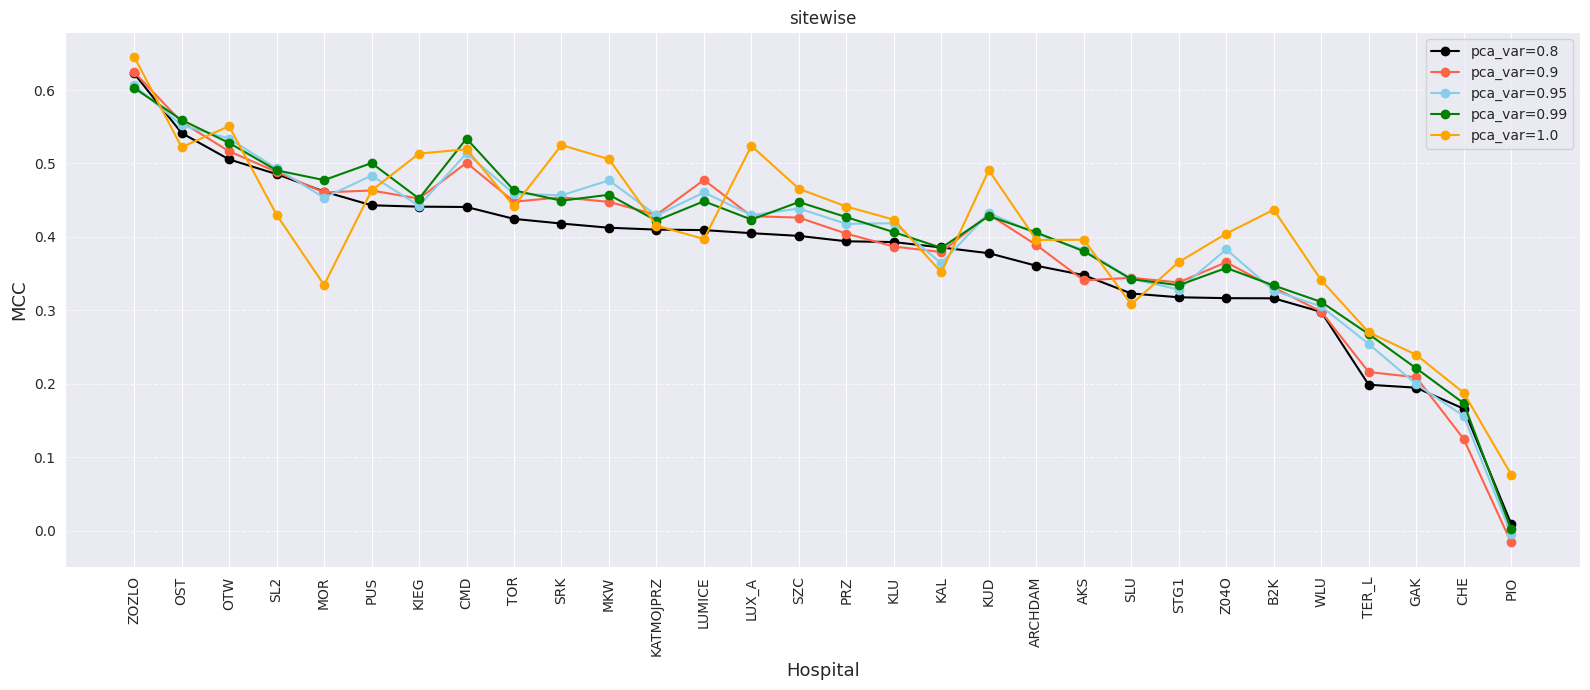

In [14]:
for metric in metrics_to_plot:
    for method in all_methods:

        plt.figure(figsize=(16, 7))

        # pivot: pca_var x hospital (wartości: metric)
        pivot_df = results_df[results_df['method'] == method].pivot_table(
            index='pca_var',
            columns='hospital',
            values=metric,
            aggfunc='mean'
        )

        reference_series = pivot_df.iloc[0]
        sort_idx = reference_series.values.argsort()[::-1]
        hospitals_sorted = reference_series.index.values[sort_idx]

        for pca_idx, pca in enumerate(pivot_df.index):
            row = pivot_df.loc[pca]
            values = [row.get(h, np.nan) for h in hospitals_sorted]

            plt.plot(
                hospitals_sorted,
                values,
                marker='o',
                linestyle='-',
                color=color_grid[pca_idx % len(color_grid)],
                label=f"pca_var={pca}"
            )

        plt.ylabel(metric.upper(), fontsize=13)
        plt.xlabel("Hospital", fontsize=13)
        plt.xticks(rotation=90)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title(f"{method}")
        plt.legend()
        plt.tight_layout()
        plt.show()


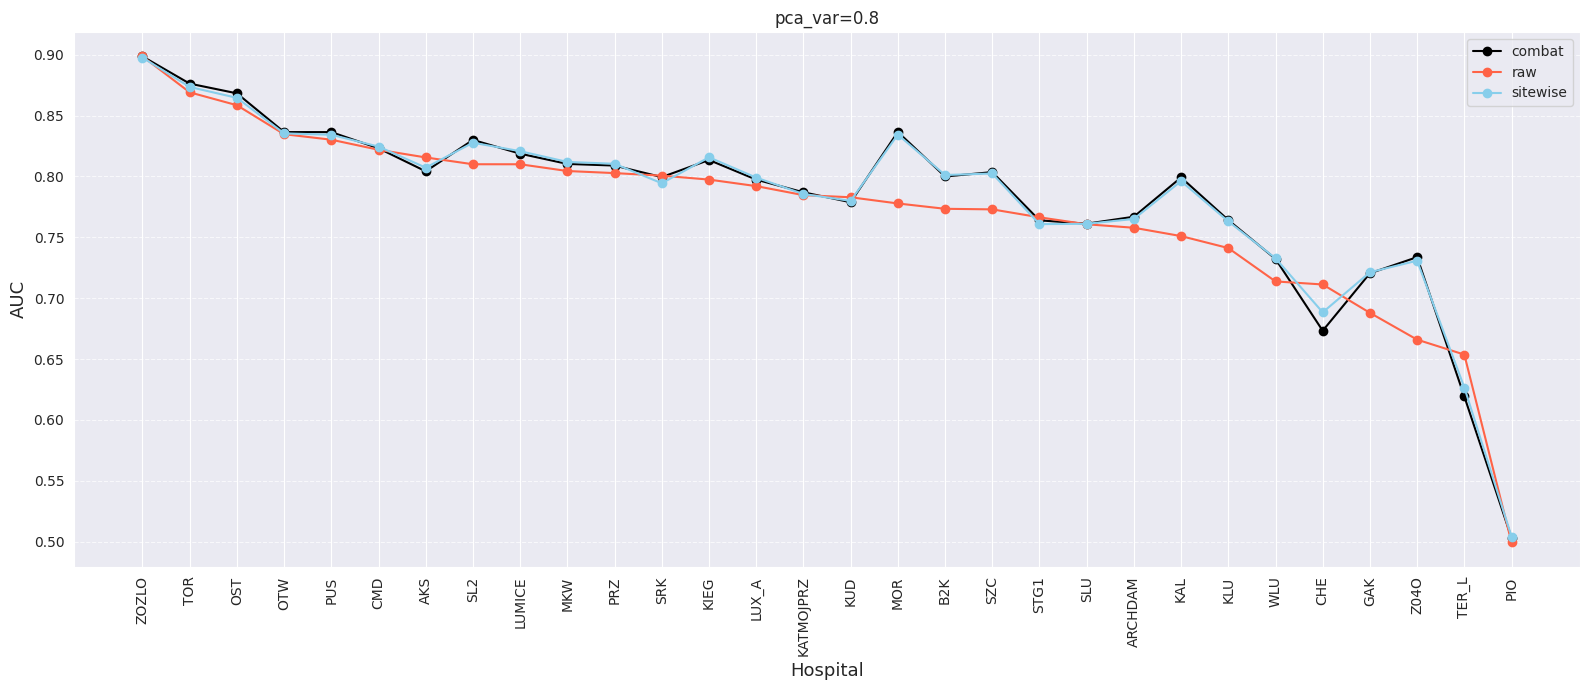

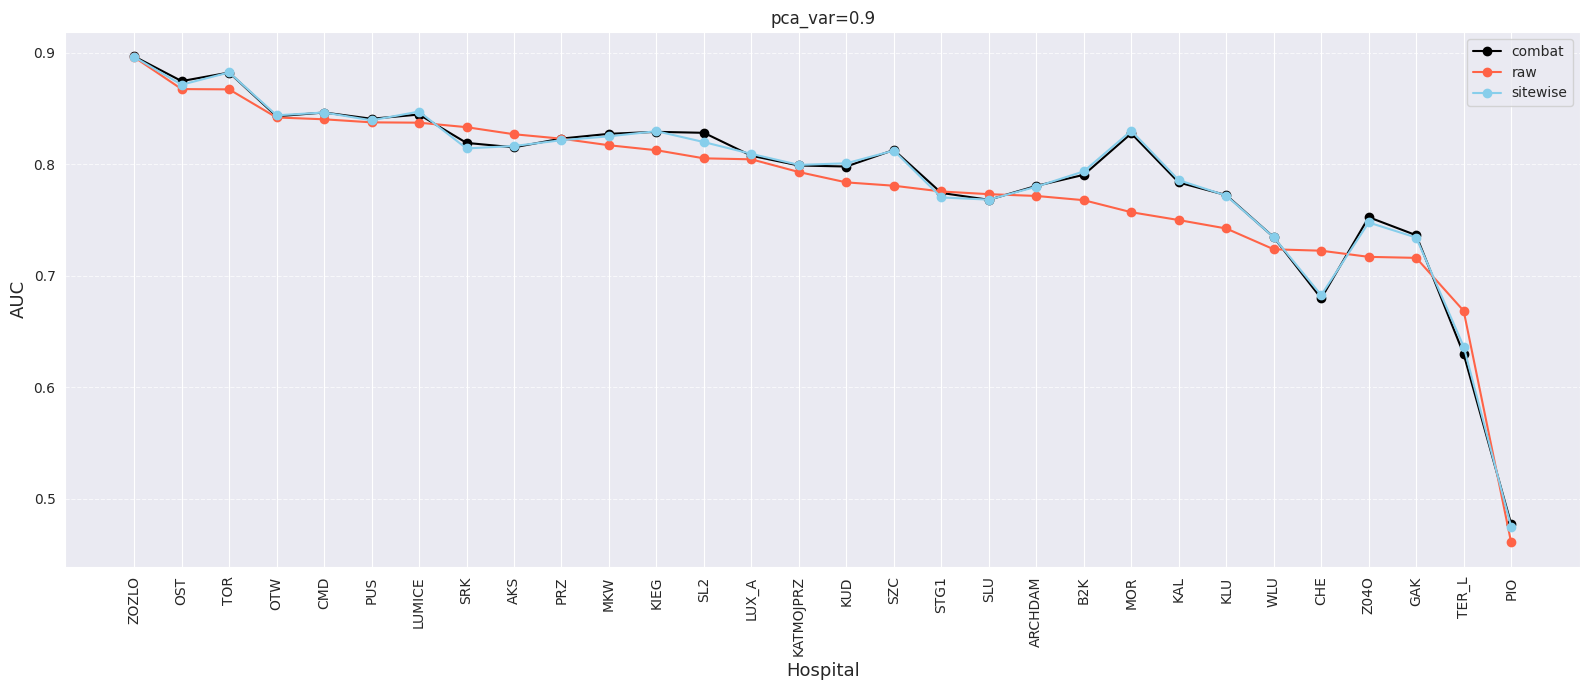

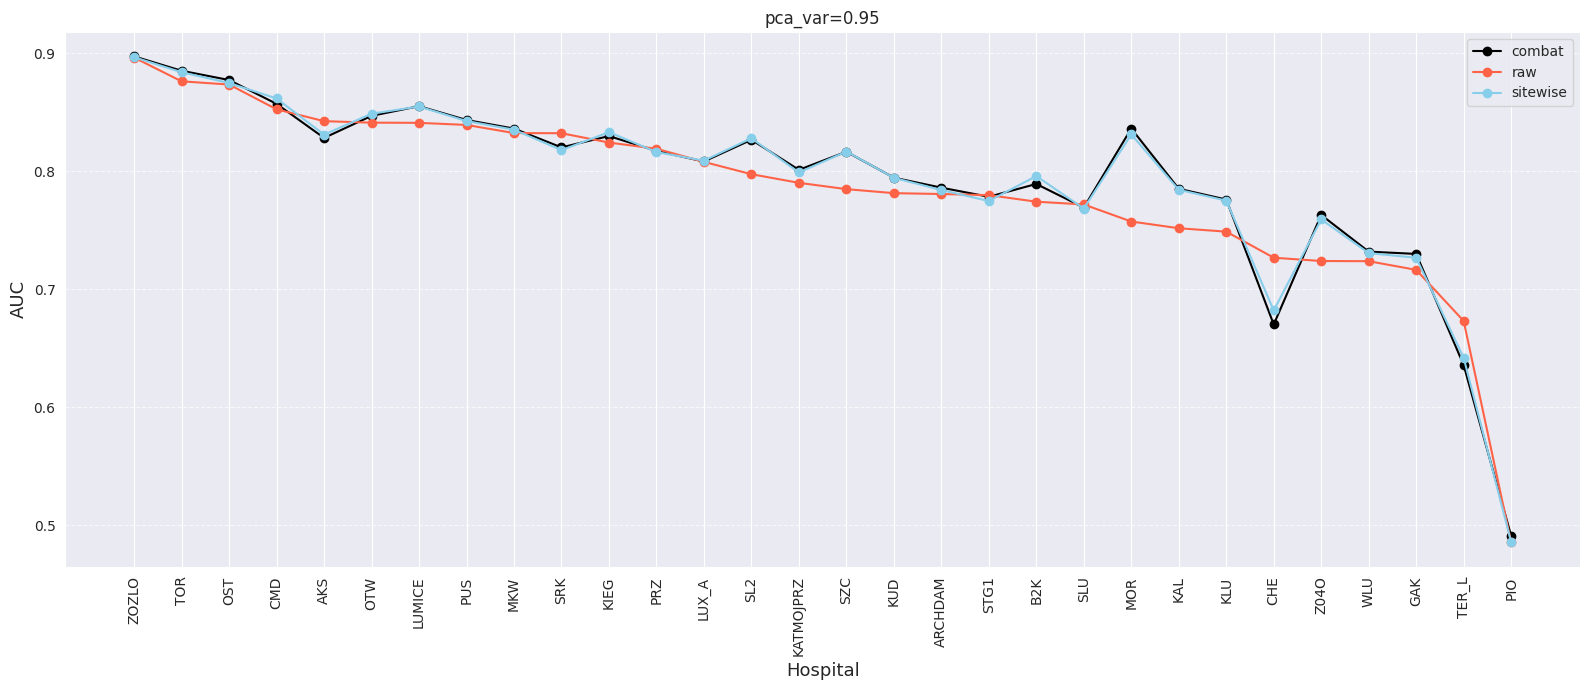

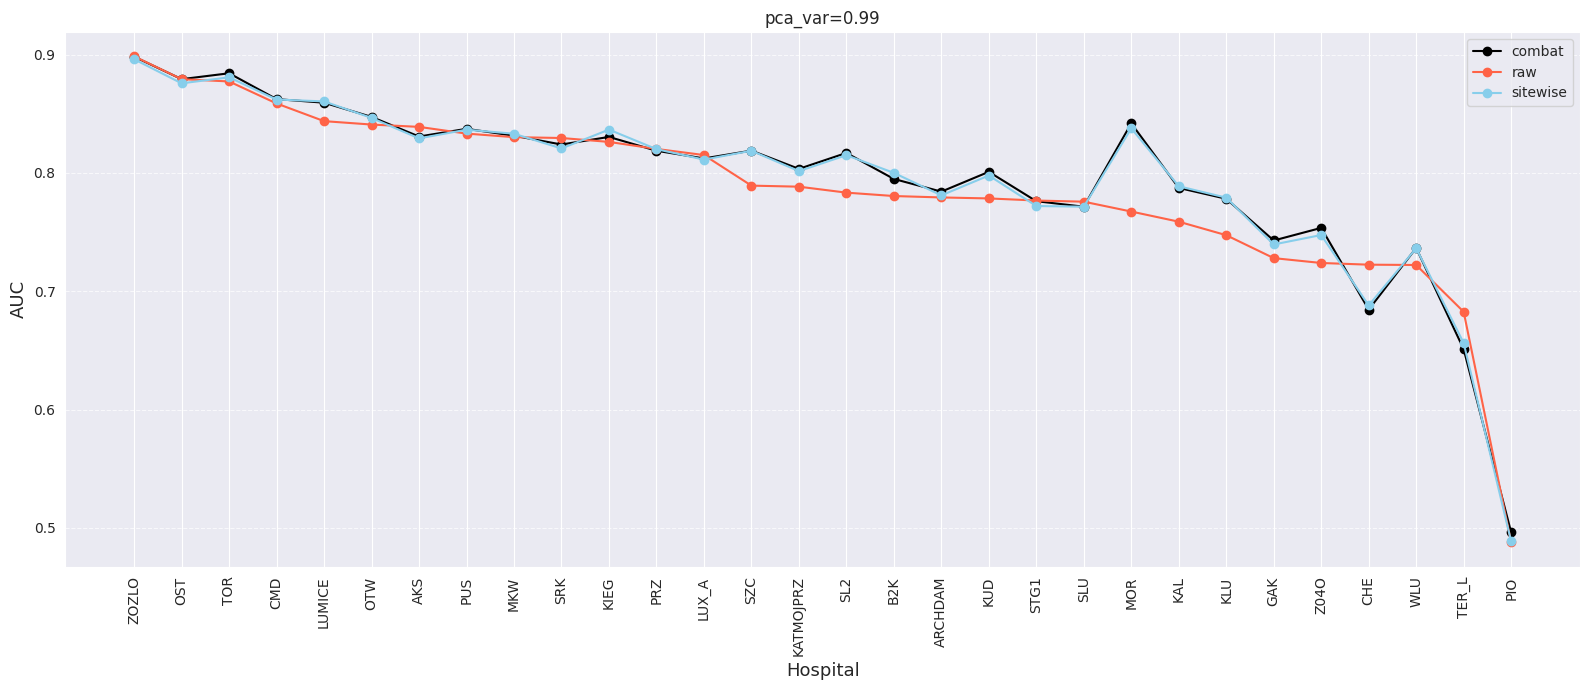

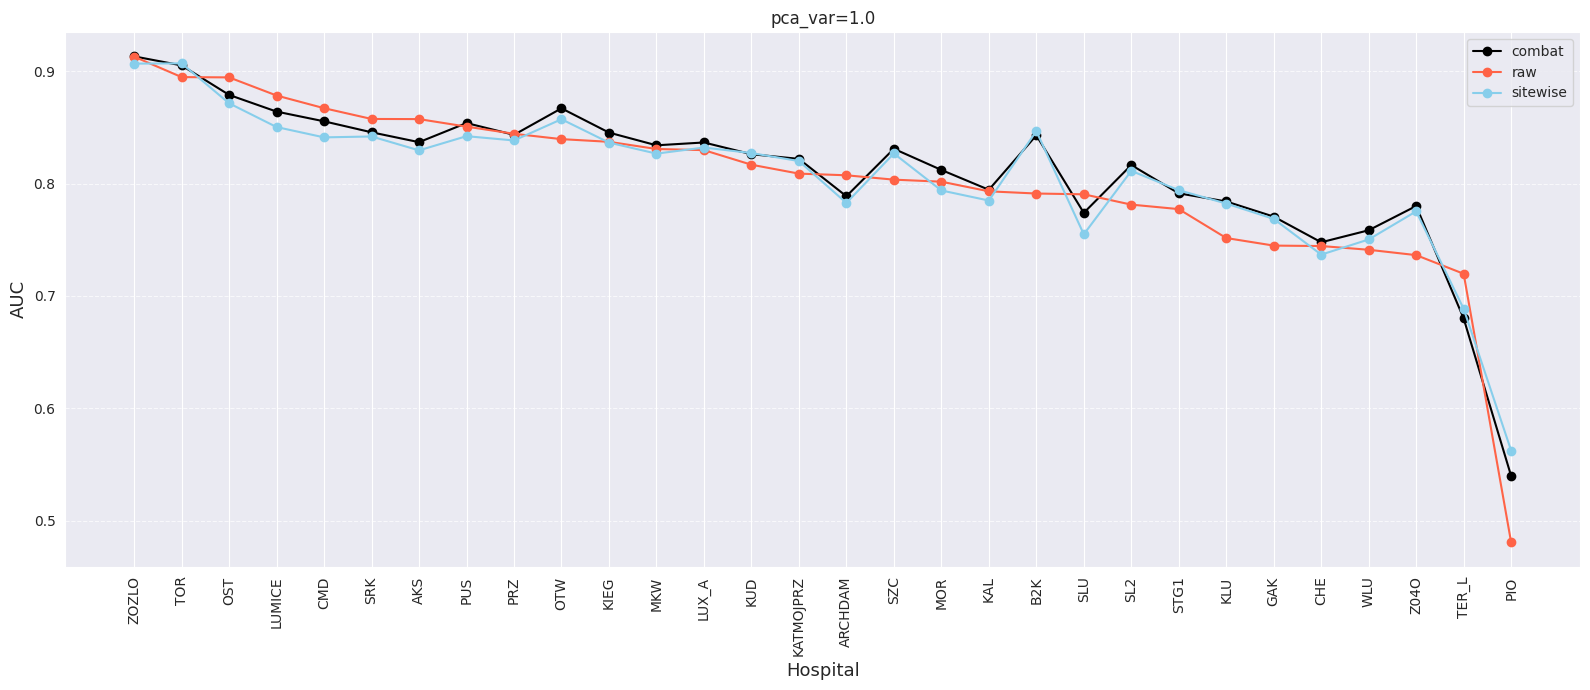

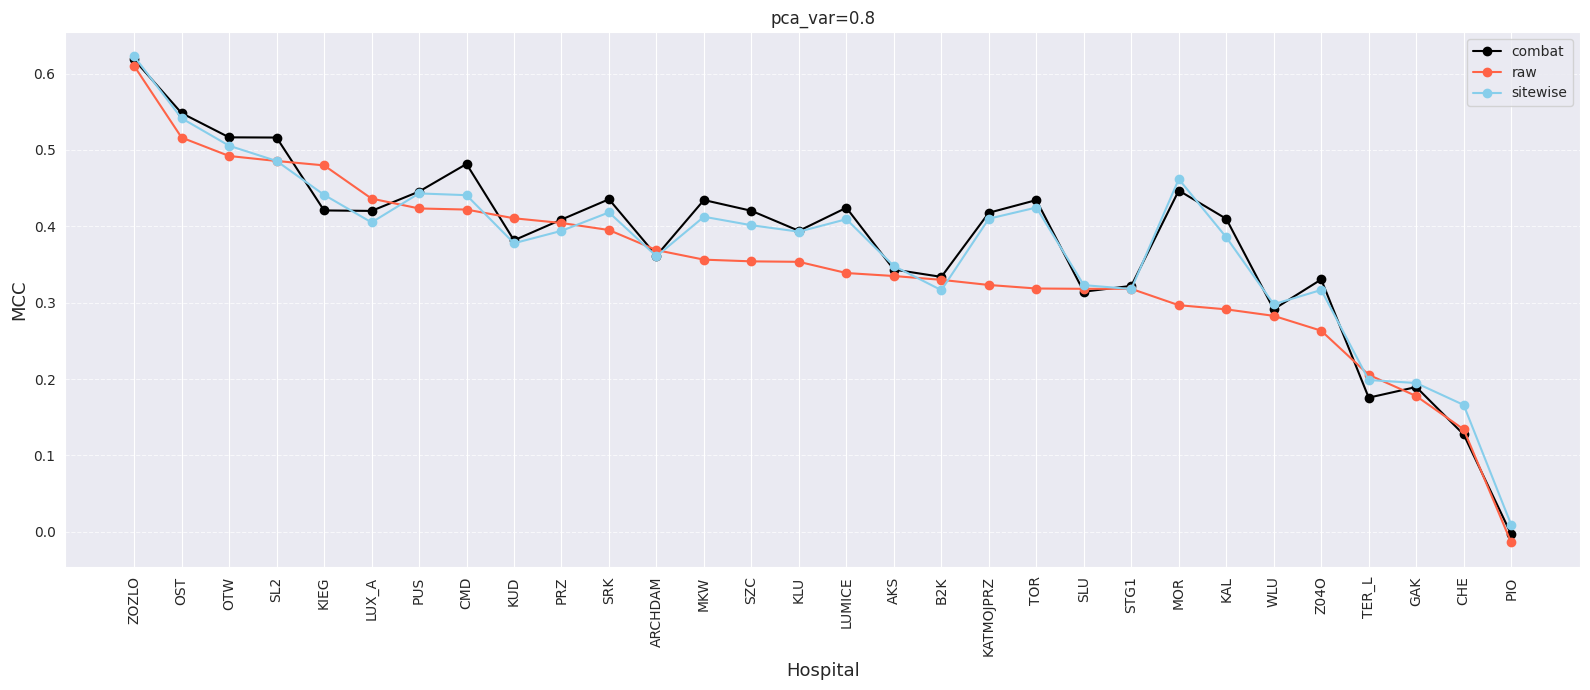

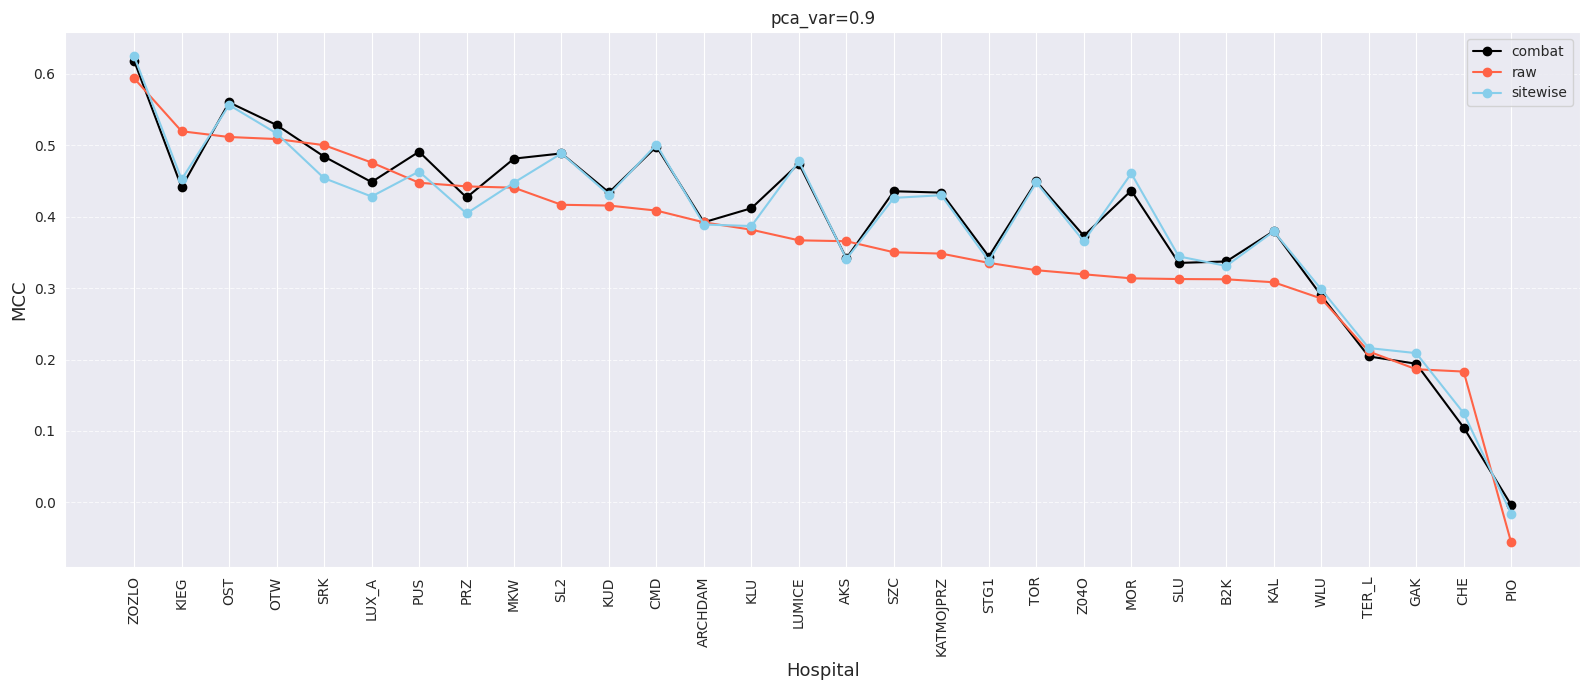

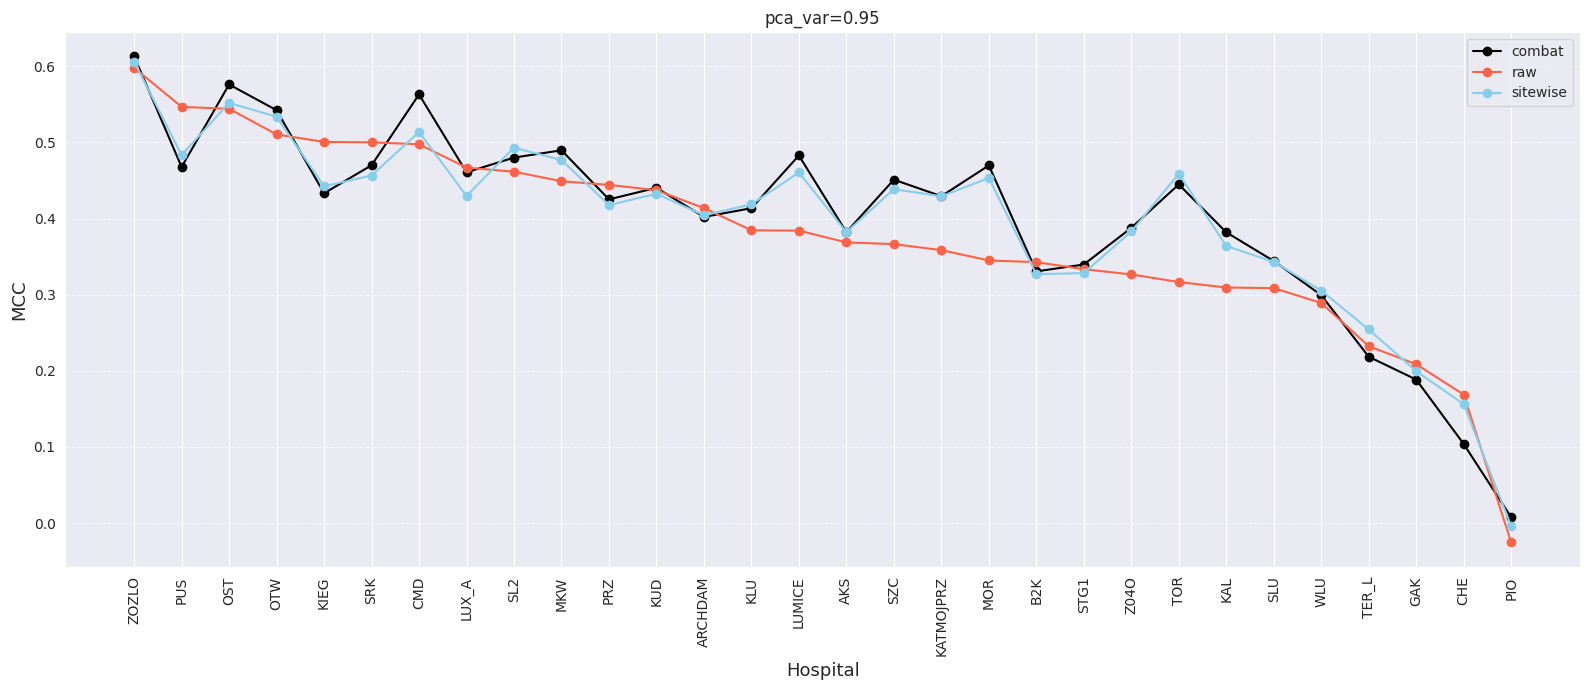

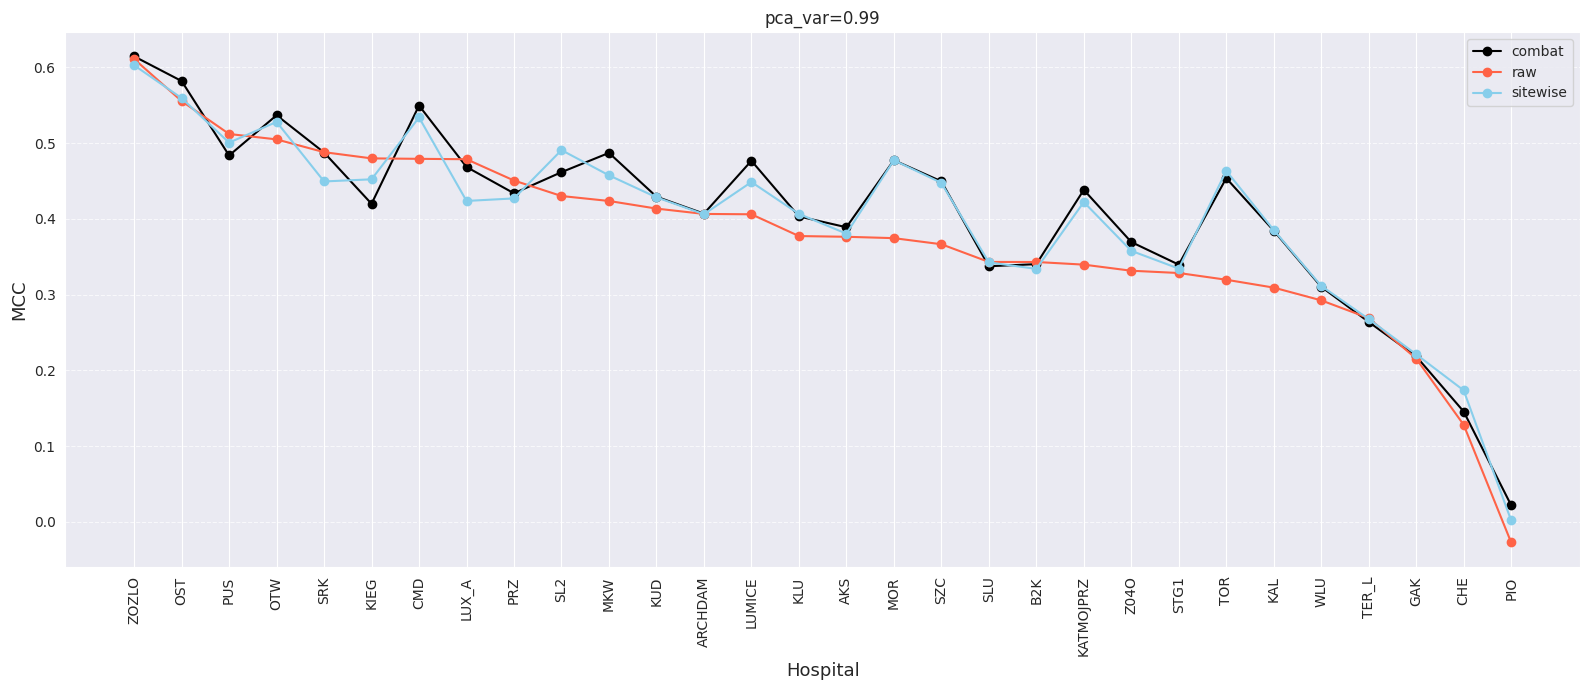

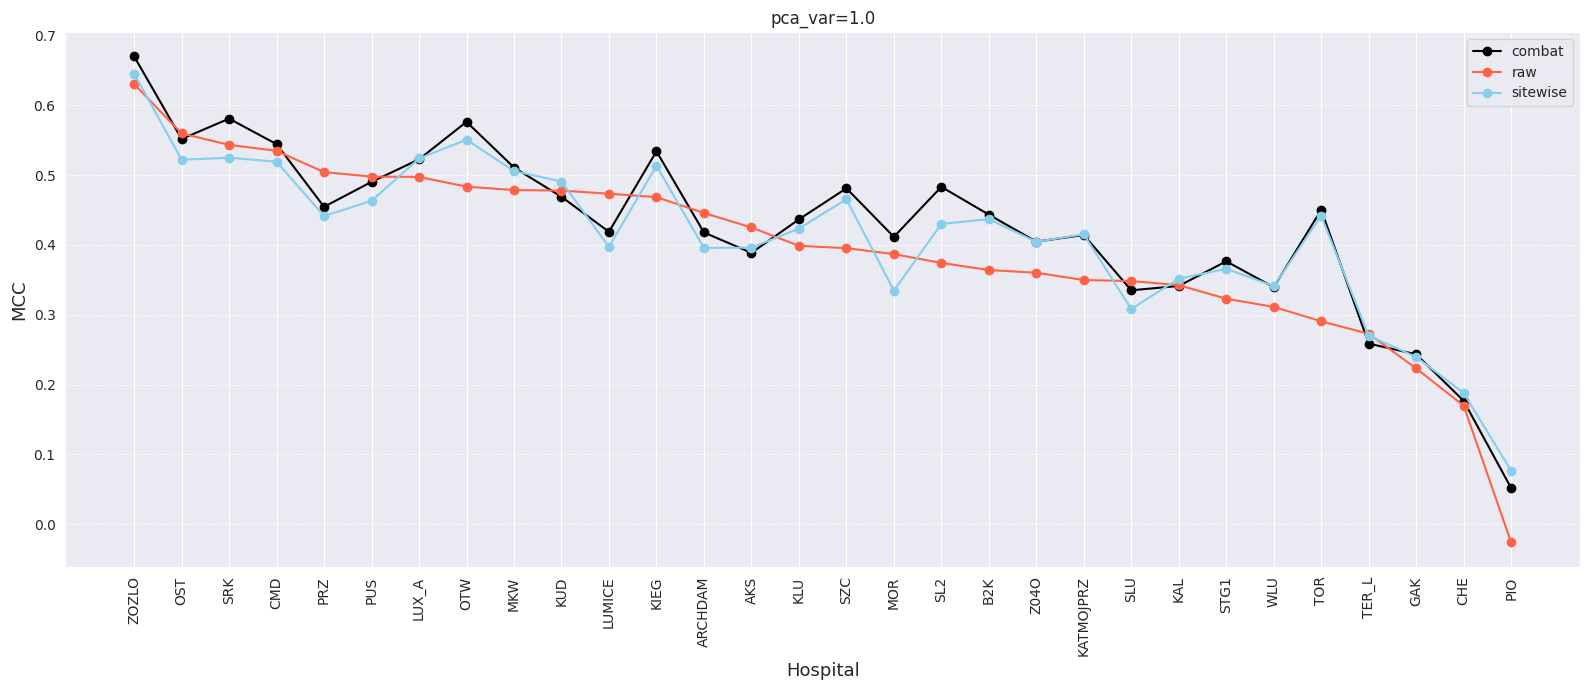

In [15]:
for metric in metrics_to_plot:
    for pca in all_pca:

        plt.figure(figsize=(16, 7))

        # pivot: method x hospital
        pivot_df = results_df[results_df['pca_var'] == pca].pivot_table(
            index='method',
            columns='hospital',
            values=metric,
            aggfunc='mean'
        )

        # sortowanie po RAW
        reference_series = pivot_df.loc['raw']
        sort_idx = reference_series.values.argsort()[::-1]
        hospitals_sorted = reference_series.index.values[sort_idx]

        # wykresy metod
        for method_idx, method in enumerate(pivot_df.index):
            row = pivot_df.loc[method]
            values = [row.get(h, np.nan) for h in hospitals_sorted]

            plt.plot(
                hospitals_sorted,
                values,
                marker='o',
                linestyle='-',
                color=color_grid[method_idx % len(color_grid)],
                label=method
            )

        plt.ylabel(metric.upper(), fontsize=13)
        plt.xlabel("Hospital", fontsize=13)
        plt.xticks(rotation=90)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title(f"pca_var={pca}")
        plt.legend()
        plt.tight_layout()
        plt.show()
